In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
import supy as sp
import os
from shutil import copyfile
import geopandas as gpd
import pickle
pd.options.mode.chained_assignment = None
from IPython.display import clear_output
from alb_LAI_util import generate_array_dif, generate_array_same, modify_attr,func_parse_date

# Parameters to tune for $\alpha$

- $\alpha_{LAI_{max}}$
- $\alpha_{LAI_{min}}$

# Necessary functions for analysis

## Reading data, calculating $\alpha$ and plotting gainst the observation (saving to pickle files)

In [25]:
def read_plot(years,name,multiple_run=0):

    for year in years:
        print(name+'-'+str(year))
        df=pd.read_csv('data/data_csv_zip_clean/'+name+'_clean.csv.gz')
        df.time=pd.to_datetime(df.time)
        df=df.set_index(['time'])


        period_start=str(year)+'-01-01'
        period_end=str(year+1)+'-01-01'
        df_period=df[(df.index>=period_start) & (df.index<period_end)]



        df_period=df_period[df_period.SWIN>5]
        df_period=df_period[(df_period.index.hour <=14) & (df_period.index.hour >=10)]
        alb_raw=df_period['SWOUT']/df_period['SWIN']
        alb_raw=alb_raw.resample('1D').mean()
        alb=alb_raw[(alb_raw>0) & (alb_raw<1)]


        alb_avg_day=pd.DataFrame(alb,columns=['alb'])



        a=alb_avg_day.index.strftime('%j')
        alb_avg_day['DOY']=[int(b) for b in a]


        copyfile("./runs/data/"+name+"_"+str(year)+"_data_60.txt", "runs/run/input/Kc_2012_data_60.txt")
        df_forcing=pd.read_csv('runs/run'+'/Input/'+'kc'+'_'+'2012'+'_data_60.txt',sep=' ',
                                        parse_dates={'datetime': [0, 1, 2, 3]},
                                        keep_date_col=True,
                                        date_parser=func_parse_date)


        
        df_forcing.loc[:,'snow']=.8
        rol=df_forcing.Tair.rolling(5).mean()
        snowdetected=1
        for i in range(len(df_forcing)):

            if snowdetected==1:
                if rol.iloc[i]>=5:
                    df_forcing.loc[df_forcing.iloc[i].name,'snow']=0
                    snowdetected=0
                else:
                    df_forcing.loc[df_forcing.iloc[i].name,'snow']=0.8
            else:
                df_forcing.loc[df_forcing.iloc[i].name,'snow']=0


            if (df_forcing.iloc[i].Tair<0) and (df_forcing.iloc[i].rain>0):
                df_forcing.loc[df_forcing.iloc[i].name,'snow']=0.8
                snowdetected=1
                

        all_sites_info =  pd.read_csv('site_info.csv')
        site_info=all_sites_info[all_sites_info['Site Id'] == name]
        df = pd.DataFrame(
            {'Site': [name],
            'Latitude': [site_info['Latitude (degrees)']],
            'Longitude': [site_info['Longitude (degrees)']]})

        

        path_runcontrol = Path('runs/run'+'/') / 'RunControl.nml'
        df_state_init = sp.init_supy(path_runcontrol)


        df_state_init,level=modify_attr(df_state_init, df, name)

        if level==1:
            attrs=[
                df_state_init.albmin_dectr,
                df_state_init.albmax_dectr
                ]
        elif level==0:
            attrs=[
                df_state_init.albmin_evetr,
                df_state_init.albmax_evetr
                ]
        elif level ==2:
            attrs=[
                df_state_init.albmin_grass,
                df_state_init.albmax_grass
                ]

        with open('outputs/albedo/'+name+'-attrs_albedo.pkl','wb') as f:
            pickle.dump(attrs, f)
        
        grid = df_state_init.index[0]
        df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)
    
        if multiple_run == 0:
            df_output, df_state_final = sp.run_supy(df_forcing_run, df_state_init, save_state=False)

        if multiple_run == 1:
            error=20
            for i in range(10):

                if (error <= 0.1):
                    break
                df_output, df_state_final = sp.run_supy(df_forcing_run, df_state_init,save_state=False)
                final_state = df_state_final[df_state_init.columns.levels[0]].iloc[1]
                df_state_init.iloc[0] = final_state
                soilstore_before = df_state_final.soilstore_id.iloc[0]
                soilstore_after = df_state_final.soilstore_id.iloc[1]
                diff_soil = sum(abs(soilstore_after-soilstore_before))
                error = 100*diff_soil/soilstore_before.mean()
                print(error) 

        df_output_2=df_output.SUEWS.loc[grid]
        df_output_2=df_output_2[df_output_2.index.year>=year]
   
        alb_model=pd.DataFrame(df_output_2.AlbBulk)
        a=alb_model.index.strftime('%j')
        alb_model['DOY']=[int(b) for b in a]


        Tair=df_forcing_run.Tair.resample('1d', closed='left',label='right').mean()
        Tair=pd.DataFrame(Tair)
        a=Tair.index.strftime('%j')
        Tair['DOY']=[int(b) for b in a]

        lai=df_output_2.LAI
        lai=lai.resample('1d', closed='left',label='right').mean()
        lai=pd.DataFrame(lai)
        a=lai.index.strftime('%j')
        lai['DOY']=[int(b) for b in a]

        snow=df_forcing.snow
        snow.index=df_forcing.datetime
        snow=snow.resample('1D').mean()
        snow=pd.DataFrame(snow)
        a=snow.index.strftime('%j')
        snow['DOY']=[int(b) for b in a]

        rain=df_forcing_run.rain
        rain=rain.resample('1d', closed='left',label='right').sum()
        rain=pd.DataFrame(rain)
        a=rain.index.strftime('%j')
        rain['DOY']=[int(b) for b in a]

        SMD=df_output_2.SMD
        SMD=SMD.resample('1d', closed='left',label='right').mean()
        SMD=pd.DataFrame(SMD)
        a=SMD.index.strftime('%j')
        SMD['DOY']=[int(b) for b in a]

        out={'obs':{'x':alb_avg_day.DOY,'y':alb_avg_day.alb},
            'model':{'x':alb_model.DOY,'y':alb_model.AlbBulk},
            'Tair':{'x':Tair.DOY,'y':Tair.Tair},
            'lai':{'x':lai.DOY,'y':lai.LAI},
            'snow':{'x':snow.DOY,'y':snow.snow},
            'rain':{'x':rain.DOY,'y':rain.rain},
            'smd':{'x':SMD.DOY,'y':SMD.SMD},
            }
        with open('outputs/albedo/'+name+'-'+str(year)+'-all-albedo.pkl','wb') as f:
            pickle.dump(out, f)

        clear_output()
    fig,axs=plt.subplots(len(years),1,figsize=(5,4*len(years)))
    plt.subplots_adjust(hspace=0.3)
    counter=-1
    for year in years:
        counter += 1
        try:
            ax=axs[counter]
        except:
            ax=axs
        with open('outputs/albedo/'+name+'-'+str(year)+'-all-albedo.pkl','rb') as f:
            out=pickle.load(f)
        ax.scatter(out['obs']['x'],out['obs']['y'],color='r',label='Obs')
        ax.plot(out['model']['x'],out['model']['y'],color='k',label='Model')
        ax.legend()
        ax.set_title(name+'-'+str(year))
        ax.set_xlabel('DOY')
        ax.set_ylabel('Albedo')

# Plotting for all the sites

## DecTr

### US-MMS

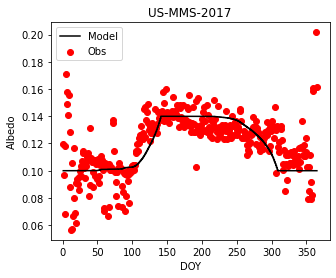

In [26]:
name='US-MMS'
years=[2017]
read_plot(years,name)

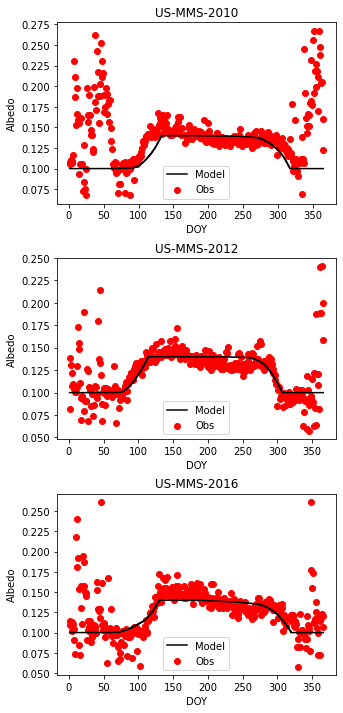

In [27]:
name='US-MMS'
years=[2010,2012,2016]
read_plot(years,name)

### US-UMB

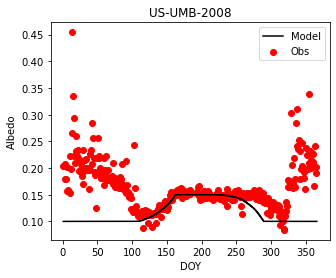

In [28]:
name='US-UMB'
years=[2008]
read_plot(years,name)

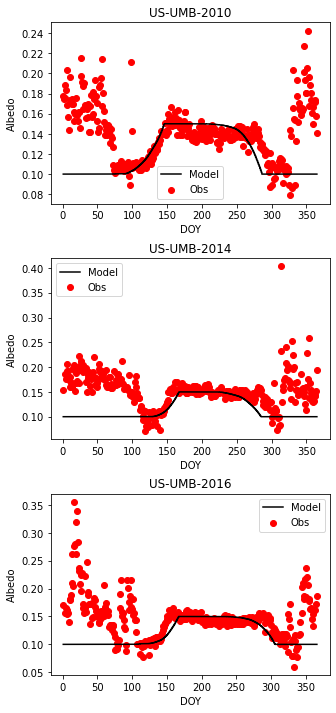

In [29]:
name='US-UMB'
years=[2010,2014,2016]
read_plot(years,name)

### US-Oho

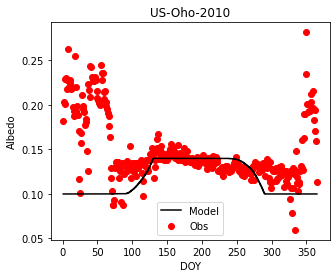

In [30]:
name='US-Oho'
years=[2010]
read_plot(years,name)

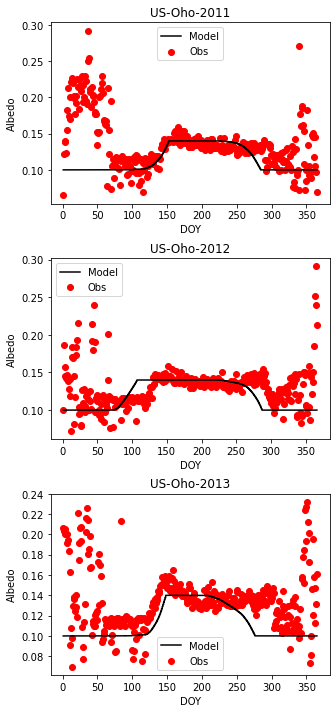

In [31]:
name='US-Oho'
years=[2011,2012,2013]
read_plot(years,name)

## EveTr

### US-Blk

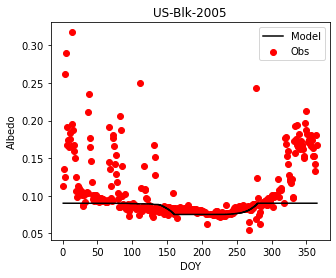

In [32]:
name='US-Blk'
years=[2005]
read_plot(years,name)

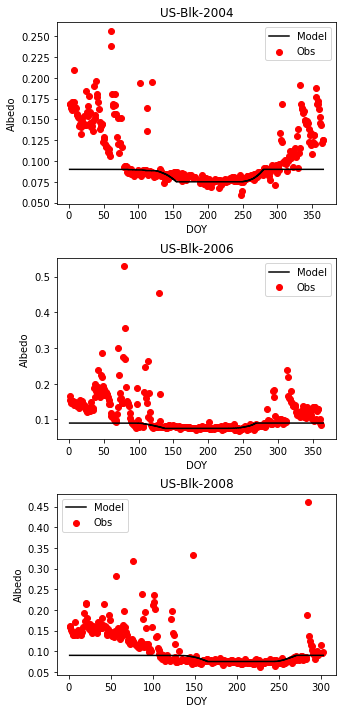

In [33]:
name='US-Blk'
years=[2004,2006,2008]
read_plot(years,name)

### CA-Obs

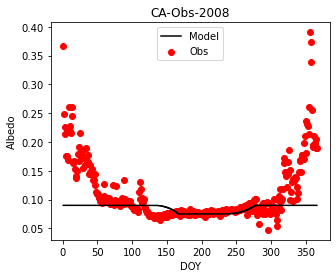

In [34]:
name='CA-Obs'
years=[2008]
read_plot(years,name)

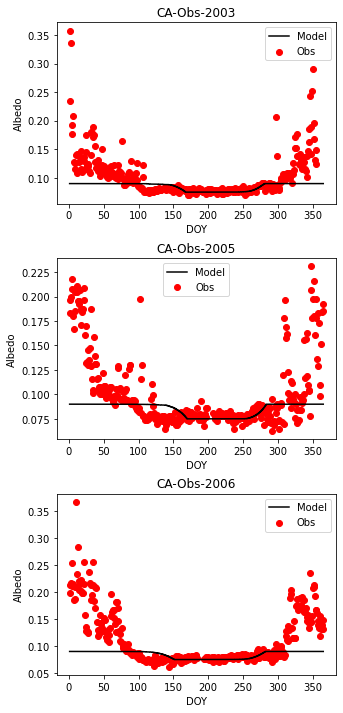

In [35]:
name='CA-Obs'
years=[2003,2005,2006]
read_plot(years,name)

### CA-Qcu

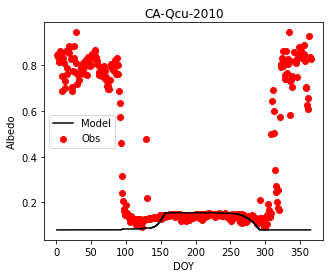

In [36]:
name='CA-Qcu'
years=[2010]
read_plot(years,name)

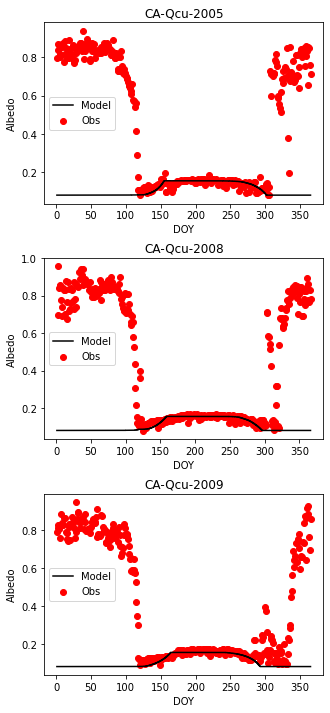

In [37]:
name='CA-Qcu'
years=[2005,2008,2009]
read_plot(years,name)

## Grass

### US-AR1

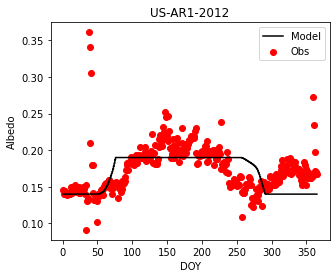

In [38]:
name='US-AR1'
years=[2012]
read_plot(years,name,multiple_run=0)

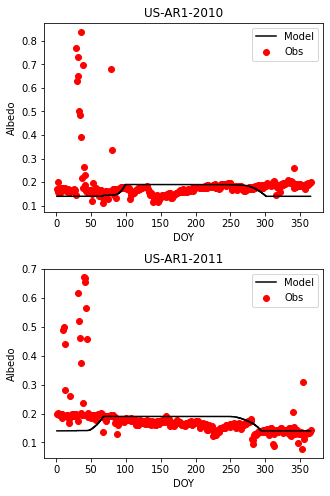

In [39]:
name='US-AR1'
years=[2010,2011]
read_plot(years,name,multiple_run=0)

### US-KUT

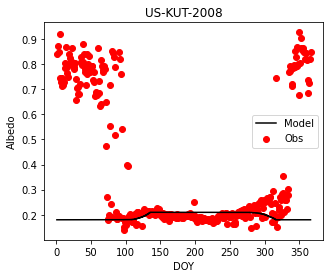

In [40]:
name='US-KUT'
years=[2008]
read_plot(years,name)

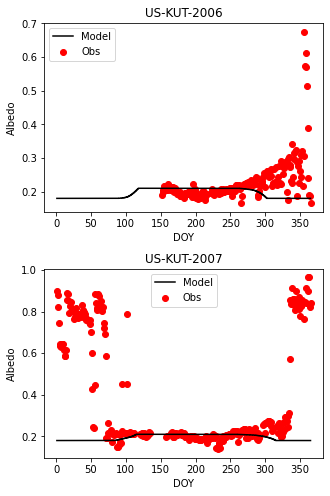

In [41]:
name='US-KUT'
years=[2006,2007]
read_plot(years,name)